# Capuchin bird Call Detection using Machine Learning
by
## Prasad Belsare

# 1. Setup and Installation

In [67]:
# Install required dependencies
!pip install tensorflow librosa scikit-learn matplotlib seaborn pydub

In [95]:
# Import core libraries
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Dense, Flatten, MaxPooling2D,
                                      Dropout, BatchNormalization,LSTM, Bidirectional, TimeDistributed, Reshape,GRU)
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau, TensorBoard)
# Audio Processing
import librosa
import librosa.display

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc)

print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")

TensorFlow version: 2.19.0
Librosa version: 0.11.0


# 2. Configuration and Reproducibility

In [71]:
# Configuration parameters
CONFIG = {
    # Paths
    'data_base': '/content/drive/MyDrive/Colab Notebooks/MS course project/data',

    # Audio parameters
    'sample_rate': 16000,
    'audio_length': 48000,  # 3 seconds at 16kHz
    'n_fft': 320,
    'hop_length': 32,
    'n_mels': 128,

    # Training parameters
    'batch_size': 16,
    'epochs': 50,
    'learning_rate': 0.001,
    'validation_split': 0.2,

    # Model selection
    'model_types': ['cnn', 'cnn_lstm', 'cnn_gru'],

    # Model parameters
    'dropout_rate': 0.3,
    'filters': [16, 32, 64],
    'dense_units': 128,

    # Prediction threshold
    'prediction_threshold': 0.5,
    'detection_threshold': 0.99,

    # Seeds for reproducibility
    'seed': 42
}

In [72]:
# Set random seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(CONFIG['seed'])
print("Seeds set for reproducibility")

Seeds set for reproducibility


In [73]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
DATA_BASE = CONFIG['data_base']
POS = os.path.join(DATA_BASE, 'Capuchinbird_Clips')
NEG = os.path.join(DATA_BASE, 'Non_Capuchinbird_Clips')
FOREST = os.path.join(DATA_BASE, 'Forest Recordings')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Exploratory Data Analysis

In [74]:
# Analyze audio file lengths
def analyze_audio_lengths(directory):
    lengths = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            filepath = os.path.join(directory, file)
            wav, _ = librosa.load(filepath, sr=CONFIG['sample_rate'], mono=True)
            lengths.append(len(wav))
    return lengths

print("Analyzing audio file lengths...")
pos_lengths = analyze_audio_lengths(POS)
neg_lengths = analyze_audio_lengths(NEG)

print("AUDIO LENGTH STATISTICS")
print(f"\nPositive samples (Capuchinbird):")
print(f"  Mean: {np.mean(pos_lengths):.0f} samples ({np.mean(pos_lengths)/CONFIG['sample_rate']:.2f}s)")
print(f"  Min: {np.min(pos_lengths)} samples ({np.min(pos_lengths)/CONFIG['sample_rate']:.2f}s)")
print(f"  Max: {np.max(pos_lengths)} samples ({np.max(pos_lengths)/CONFIG['sample_rate']:.2f}s)")
print(f"  Std: {np.std(pos_lengths):.0f} samples")

print(f"\nNegative samples (Not Capuchinbird):")
print(f"  Mean: {np.mean(neg_lengths):.0f} samples ({np.mean(neg_lengths)/CONFIG['sample_rate']:.2f}s)")
print(f"  Min: {np.min(neg_lengths)} samples ({np.min(neg_lengths)/CONFIG['sample_rate']:.2f}s)")
print(f"  Max: {np.max(neg_lengths)} samples ({np.max(neg_lengths)/CONFIG['sample_rate']:.2f}s)")
print(f"  Std: {np.std(neg_lengths):.0f} samples")

Analyzing audio file lengths...
AUDIO LENGTH STATISTICS

Positive samples (Capuchinbird):
  Mean: 54157 samples (3.38s)
  Min: 32000 samples (2.00s)
  Max: 80000 samples (5.00s)
  Std: 8173 samples

Negative samples (Not Capuchinbird):
  Mean: 49298 samples (3.08s)
  Min: 47230 samples (2.95s)
  Max: 63088 samples (3.94s)
  Std: 1917 samples



Visualizing samples:
  Positive: XC114132-0.wav
  Negative: afternoon-birds-song-in-forest-12.wav


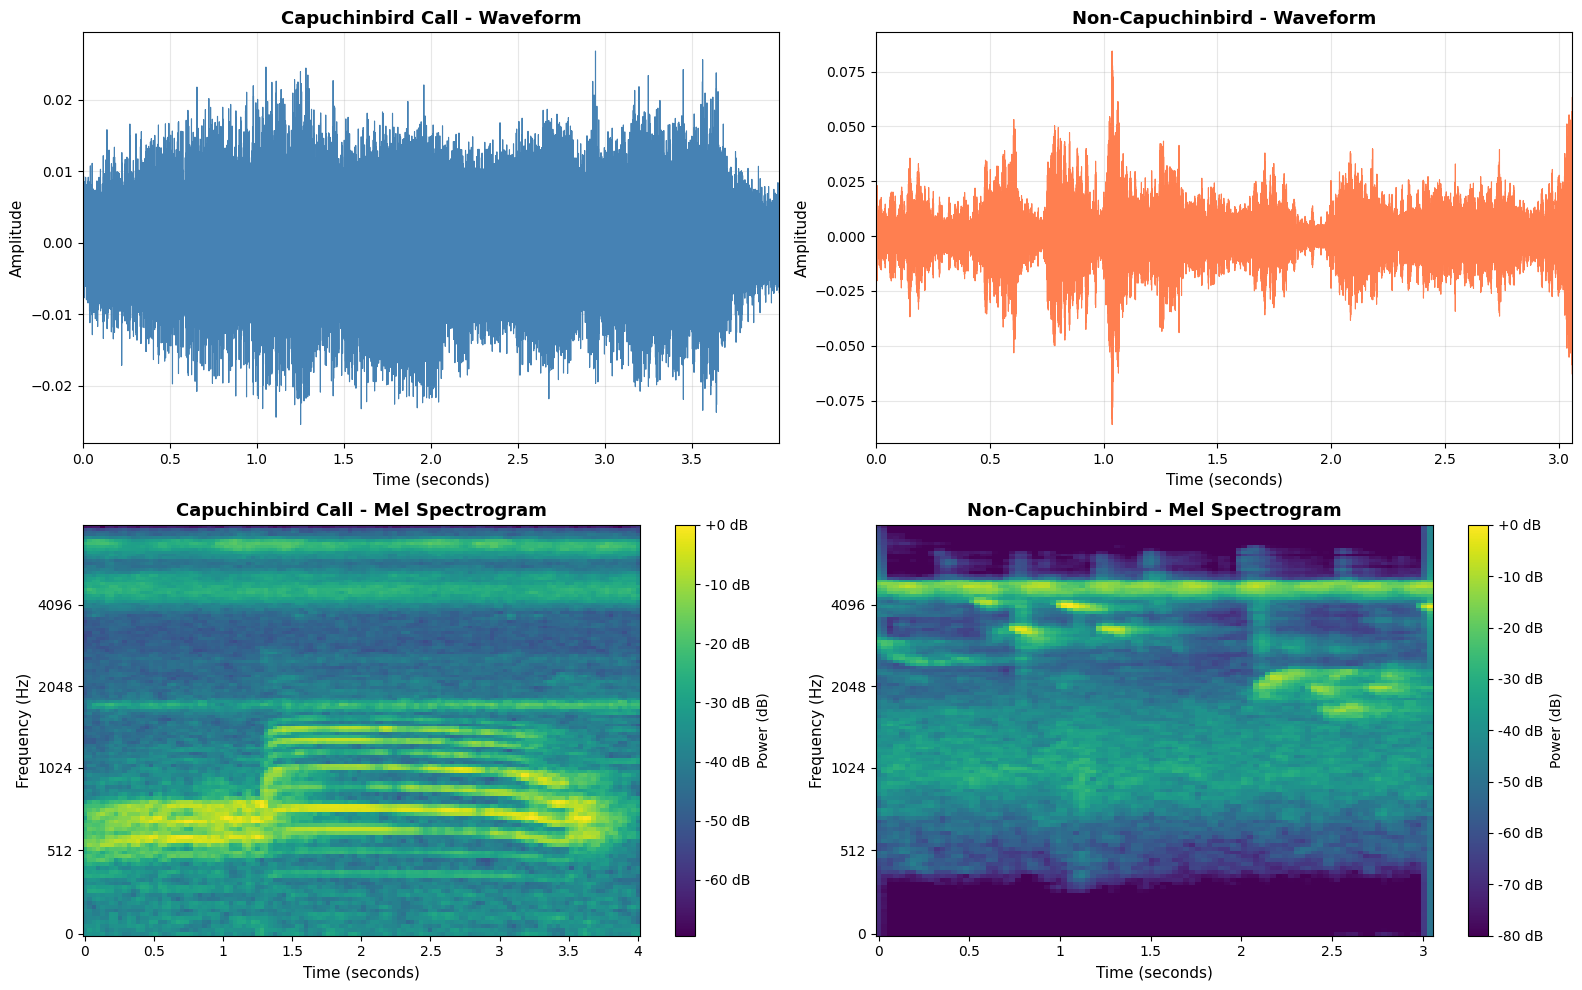

In [75]:
# Visualize sample waveforms and spectrograms
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Load sample files
pos_files = [f for f in os.listdir(POS) if f.endswith('.wav')]
neg_files = [f for f in os.listdir(NEG) if f.endswith('.wav')]

if len(pos_files) == 0 or len(neg_files) == 0:
    print("Error: No .wav files found in directories!")
else:
    pos_file = os.path.join(POS, pos_files[0])
    neg_file = os.path.join(NEG, neg_files[0])

    print(f"\nVisualizing samples:")
    print(f"  Positive: {pos_files[0]}")
    print(f"  Negative: {neg_files[0]}")

    # Load audio files
    pos_wav, _ = librosa.load(pos_file, sr=CONFIG['sample_rate'], mono=True)
    neg_wav, _ = librosa.load(neg_file, sr=CONFIG['sample_rate'], mono=True)

    # Time axis for waveforms
    time_pos = np.arange(len(pos_wav)) / CONFIG['sample_rate']
    time_neg = np.arange(len(neg_wav)) / CONFIG['sample_rate']

    # Plot waveforms
    axes[0, 0].plot(time_pos, pos_wav, color='steelblue', linewidth=0.8)
    axes[0, 0].set_title('Capuchinbird Call - Waveform', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('Time (seconds)', fontsize=11)
    axes[0, 0].set_ylabel('Amplitude', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, time_pos[-1]])

    axes[0, 1].plot(time_neg, neg_wav, color='coral', linewidth=0.8)
    axes[0, 1].set_title('Non-Capuchinbird - Waveform', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Time (seconds)', fontsize=11)
    axes[0, 1].set_ylabel('Amplitude', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([0, time_neg[-1]])

    # Create mel spectrograms
    pos_spec = librosa.feature.melspectrogram(y=pos_wav, sr=CONFIG['sample_rate'],
                                              n_mels=CONFIG['n_mels'], fmax=8000)
    pos_spec_db = librosa.power_to_db(pos_spec, ref=np.max)

    neg_spec = librosa.feature.melspectrogram(y=neg_wav, sr=CONFIG['sample_rate'],
                                              n_mels=CONFIG['n_mels'], fmax=8000)
    neg_spec_db = librosa.power_to_db(neg_spec, ref=np.max)

    # Plot spectrograms
    img1 = librosa.display.specshow(pos_spec_db, sr=CONFIG['sample_rate'],
                                     x_axis='time', y_axis='mel',
                                     ax=axes[1, 0], cmap='viridis')
    axes[1, 0].set_title('Capuchinbird Call - Mel Spectrogram', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Time (seconds)', fontsize=11)
    axes[1, 0].set_ylabel('Frequency (Hz)', fontsize=11)
    fig.colorbar(img1, ax=axes[1, 0], format='%+2.0f dB', label='Power (dB)')

    img2 = librosa.display.specshow(neg_spec_db, sr=CONFIG['sample_rate'],
                                     x_axis='time', y_axis='mel',
                                     ax=axes[1, 1], cmap='viridis')
    axes[1, 1].set_title('Non-Capuchinbird - Mel Spectrogram', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Time (seconds)', fontsize=11)
    axes[1, 1].set_ylabel('Frequency (Hz)', fontsize=11)
    fig.colorbar(img2, ax=axes[1, 1], format='%+2.0f dB', label='Power (dB)')

    plt.tight_layout()
    plt.show()


# 4. Data Loading and Preprocessing Functions

In [76]:
def load_audio_16k(filename):
    """Load audio file at 16kHz mono"""
    if isinstance(filename, tf.Tensor):
        filename = filename.numpy().decode('utf-8')
    wav, _ = librosa.load(filename, sr=CONFIG['sample_rate'], mono=True)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

def load_audio_file(path):
    """Load audio file - handles various input types"""
    if hasattr(path, 'numpy'):
        path = path.numpy()

    if isinstance(path, np.ndarray):
        if path.ndim == 0:
            path = path.item()
        else:
            path = path[0]

    if isinstance(path, bytes):
        path = path.decode('utf-8')

    wav, _ = librosa.load(path, sr=CONFIG['sample_rate'], mono=True)
    return wav.astype(np.float32)

In [77]:
def augment_audio(wav, augment=True):
    """Apply data augmentation techniques"""
    if not augment:
        return wav

    wav = wav.numpy() if isinstance(wav, tf.Tensor) else wav

    # Time stretching (±20%)
    if random.random() > 0.5:
        rate = random.uniform(0.8, 1.2)
        wav = librosa.effects.time_stretch(wav, rate=rate)

    # Pitch shifting (±2 semitones)
    if random.random() > 0.5:
        n_steps = random.randint(-2, 2)
        wav = librosa.effects.pitch_shift(wav, sr=CONFIG['sample_rate'], n_steps=n_steps)

    # Add random noise
    if random.random() > 0.5:
        noise = np.random.normal(0, 0.005, wav.shape)
        wav = wav + noise

    # Random gain
    if random.random() > 0.5:
        gain = random.uniform(0.8, 1.2)
        wav = wav * gain

    return wav

In [78]:
def preprocess(file_path, label, augment=False):
    """Preprocess audio file into spectrogram"""
    # Load audio
    wav = tf.py_function(
        func=load_audio_file,
        inp=[file_path],
        Tout=tf.float32
    )
    wav.set_shape([None])

    # Apply augmentation if requested
    if augment:
        wav = tf.py_function(
            func=lambda x: augment_audio(x, augment=True),
            inp=[wav],
            Tout=tf.float32
        )
        wav.set_shape([None])

    # Ensure fixed length (pad or trim)
    current_length = tf.shape(wav)[0]
    target_length = CONFIG['audio_length']

    wav = tf.cond(
        current_length < target_length,
        lambda: tf.concat([tf.zeros(target_length - current_length, dtype=tf.float32), wav], 0),
        lambda: wav[:target_length]
    )
    wav.set_shape([target_length])

    # Create spectrogram using STFT
    # Fix: Explicitly set fft_length to avoid implicit padding
    spectrogram = tf.signal.stft(wav,
                                  frame_length=CONFIG['n_fft'],
                                  frame_step=CONFIG['hop_length'],
                                  fft_length=CONFIG['n_fft'])
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)

    # Calculate expected shape
    n_frames = 1 + (target_length - CONFIG['n_fft']) // CONFIG['hop_length']
    n_freq_bins = CONFIG['n_fft'] // 2 + 1
    spectrogram.set_shape([n_frames, n_freq_bins, 1])

    return spectrogram, label

# 5. Dataset Preparation

In [79]:
# Collect all file paths and labels
all_files = []
all_labels = []

for file in os.listdir(POS):
    if file.endswith('.wav'):
        all_files.append(os.path.join(POS, file))
        all_labels.append(1)

for file in os.listdir(NEG):
    if file.endswith('.wav'):
        all_files.append(os.path.join(NEG, file))
        all_labels.append(0)


In [80]:
# Stratified train-test split
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels,
    test_size=CONFIG['validation_split'],
    stratify=all_labels,
    random_state=CONFIG['seed']
)

print(f"Training samples: {len(train_files)}")
print(f"Testing samples: {len(test_files)}")

Training samples: 648
Testing samples: 162


In [81]:
# Create TensorFlow datasets
def create_dataset(files, labels, batch_size, augment=False, shuffle=True):
    """Create a TensorFlow dataset from file paths and labels"""
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(files), seed=CONFIG['seed'])

    dataset = dataset.map(
        lambda x, y: preprocess(x, y, augment=augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create training dataset with augmentation
train_dataset = create_dataset(
    train_files, train_labels,
    CONFIG['batch_size'],
    augment=True,  # Enable augmentation for training
    shuffle=True
)

# Create test dataset without augmentation
test_dataset = create_dataset(
    test_files, test_labels,
    CONFIG['batch_size'],
    augment=False,
    shuffle=False
)

print("Datasets created successfully")

Datasets created successfully


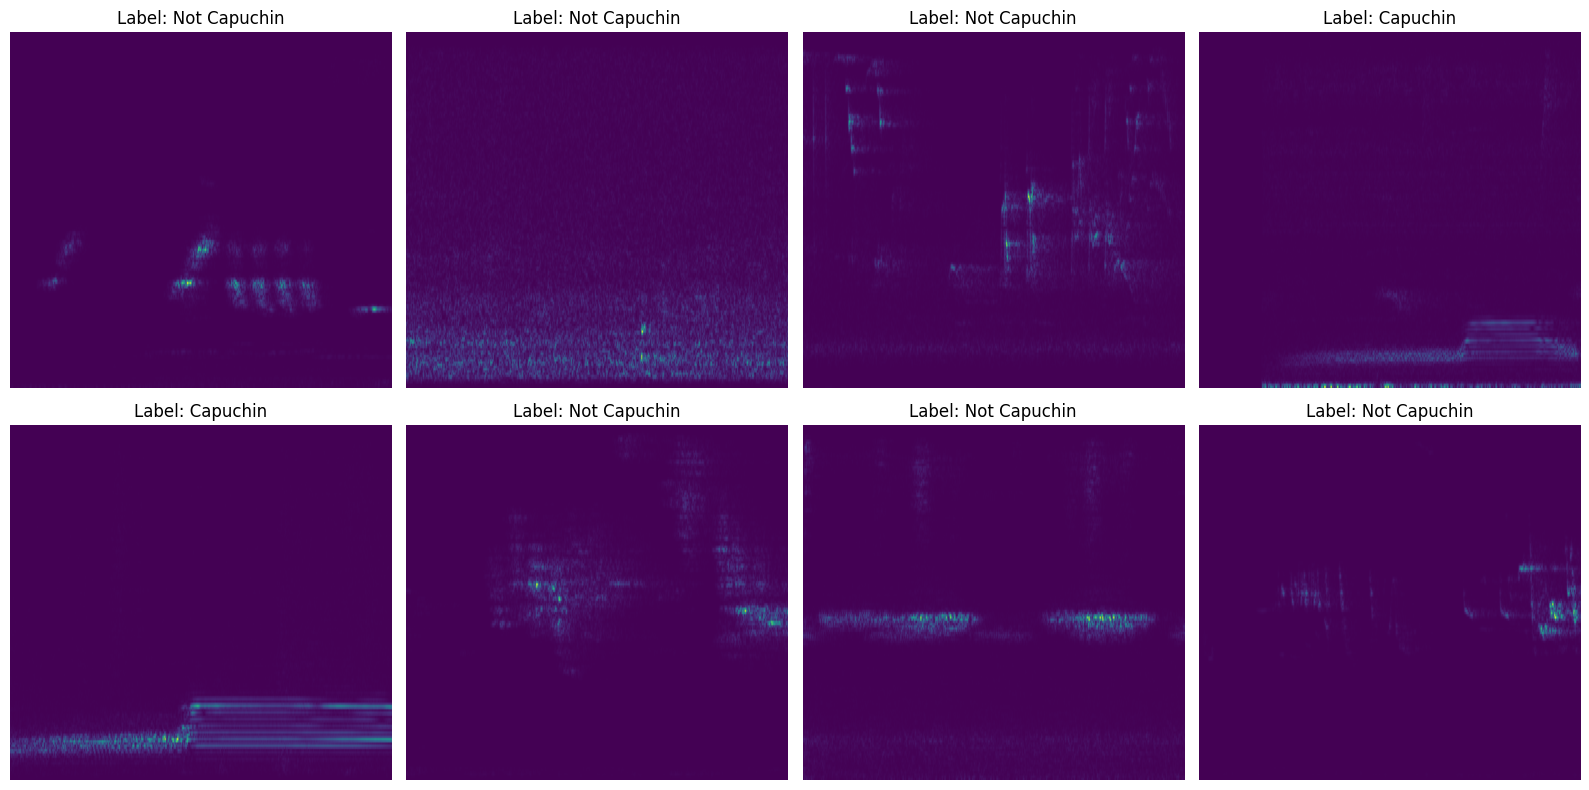

Spectrogram shape: (1491, 161, 1)


In [82]:
# Visualize a batch of spectrograms
samples, labels = train_dataset.as_numpy_iterator().next()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(8):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(samples[i].squeeze().T, aspect='auto', origin='lower', cmap='viridis')
    axes[row, col].set_title(f'Label: {"Capuchin" if labels[i] == 1 else "Not Capuchin"}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"Spectrogram shape: {samples[0].shape}")

# 6. Model Architecture

In [83]:
def build_cnn_model(input_shape):
    """Build enhanced CNN model for audio classification"""
    model = Sequential([
        # First Convolutional Block
        Conv2D(CONFIG['filters'][0], (3, 3), activation='relu',
               padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        # Second Convolutional Block
        Conv2D(CONFIG['filters'][1], (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        # Third Convolutional Block
        Conv2D(CONFIG['filters'][2], (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        # Dense Layers
        Flatten(),
        Dense(CONFIG['dense_units'], activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

In [84]:
def build_cnn_lstm_model(input_shape):
    """Build CNN+LSTM hybrid model for audio classification
    """

    model = Sequential([
        # First Convolutional Block
        Conv2D(CONFIG['filters'][0], (3, 3), activation='relu',
               padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        # Second Convolutional Block
        Conv2D(CONFIG['filters'][1], (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        # Third Convolutional Block
        Conv2D(CONFIG['filters'][2], (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        # Reshape for LSTM: (batch, time_steps, features)
        # The CNN output needs to be reshaped into a sequence
        Reshape((-1, CONFIG['filters'][2])),

        # Bidirectional LSTM layers
        # Bidirectional processes sequence forwards AND backwards
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),

        Bidirectional(LSTM(32)),
        Dropout(0.4),

        # Dense Layers
        Dense(CONFIG['dense_units'], activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

In [85]:
def build_cnn_gru_model(input_shape):
    """Build CNN+GRU hybrid model for audio classification
    """

    model = Sequential([
        # Convolutional Feature Extraction
        Conv2D(CONFIG['filters'][0], (3, 3), activation='relu',
               padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        Conv2D(CONFIG['filters'][1], (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        Conv2D(CONFIG['filters'][2], (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(CONFIG['dropout_rate']),

        # Reshape for GRU
        Reshape((-1, CONFIG['filters'][2])),

        # Bidirectional GRU layers
        Bidirectional(GRU(64, return_sequences=True)),
        Dropout(0.4),

        Bidirectional(GRU(32)),
        Dropout(0.4),

        # Classification Head
        Dense(CONFIG['dense_units'], activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

# 7. Train All Models and Compare

In [86]:
# Dictionary to store results for all models
all_results = {}
all_histories = {}
all_models = {}


for model_type in CONFIG['model_types']:
    print(f" TRAINING {model_type.upper()} MODEL")

    # Build model
    if model_type == 'cnn':
        model = build_cnn_model(input_shape)
    elif model_type == 'cnn_lstm':
        model = build_cnn_lstm_model(input_shape)
    elif model_type == 'cnn_gru':
        model = build_cnn_gru_model(input_shape)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    print(f"Total parameters: {model.count_params():,}")

    callbacks = [
        EarlyStopping(
            monitor='val_auc',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min',
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_model_{model_type}.keras',
            save_best_only=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train model
    history = model.fit(
        train_dataset,
        epochs=CONFIG['epochs'],
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=1
    )

    # Store results
    all_histories[model_type] = history
    all_models[model_type] = model

    # Evaluate on test set
    test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(test_dataset, verbose=0)

    all_results[model_type] = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_auc': test_auc,
        'total_params': model.count_params(),
        'best_epoch': np.argmax(history.history['val_auc']) + 1,
        'training_time': len(history.history['loss'])
    }

    print(f"\n {model_type.upper()} Results:")
    print(f"   Test Accuracy: {test_acc:.4f}")
    print(f"   Test AUC: {test_auc:.4f}")
    print(f"   Test Precision: {test_prec:.4f}")
    print(f"   Test Recall: {test_rec:.4f}")

print(" ALL MODELS TRAINED SUCCESSFULLY")

 TRAINING CNN MODEL
Total parameters: 30,498,753
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.7867 - auc: 0.8824 - loss: 0.6786 - precision: 0.6005 - recall: 0.8213
Epoch 1: val_auc improved from -inf to 0.87991, saving model to best_model_cnn.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 971ms/step - accuracy: 0.7881 - auc: 0.8832 - loss: 0.6763 - precision: 0.6020 - recall: 0.8221 - val_accuracy: 0.8580 - val_auc: 0.8799 - val_loss: 0.3995 - val_precision: 0.8846 - val_recall: 0.5349 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.8706 - auc: 0.9410 - loss: 0.3523 - precision: 0.7846 - recall: 0.8190
Epoch 2: val_auc did not improve from 0.87991
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 771ms/step - accuracy: 0.8713 - auc: 0.9412 - loss: 0.3518 - precision: 0.7846 - recall: 0.8202 - val_accuracy: 0.8457 - val_auc: 0.8433 - val_loss: 0.3983 - val_precision: 0.9091 - val_recall: 0.4651 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━

# 8. Plot comparison of all models

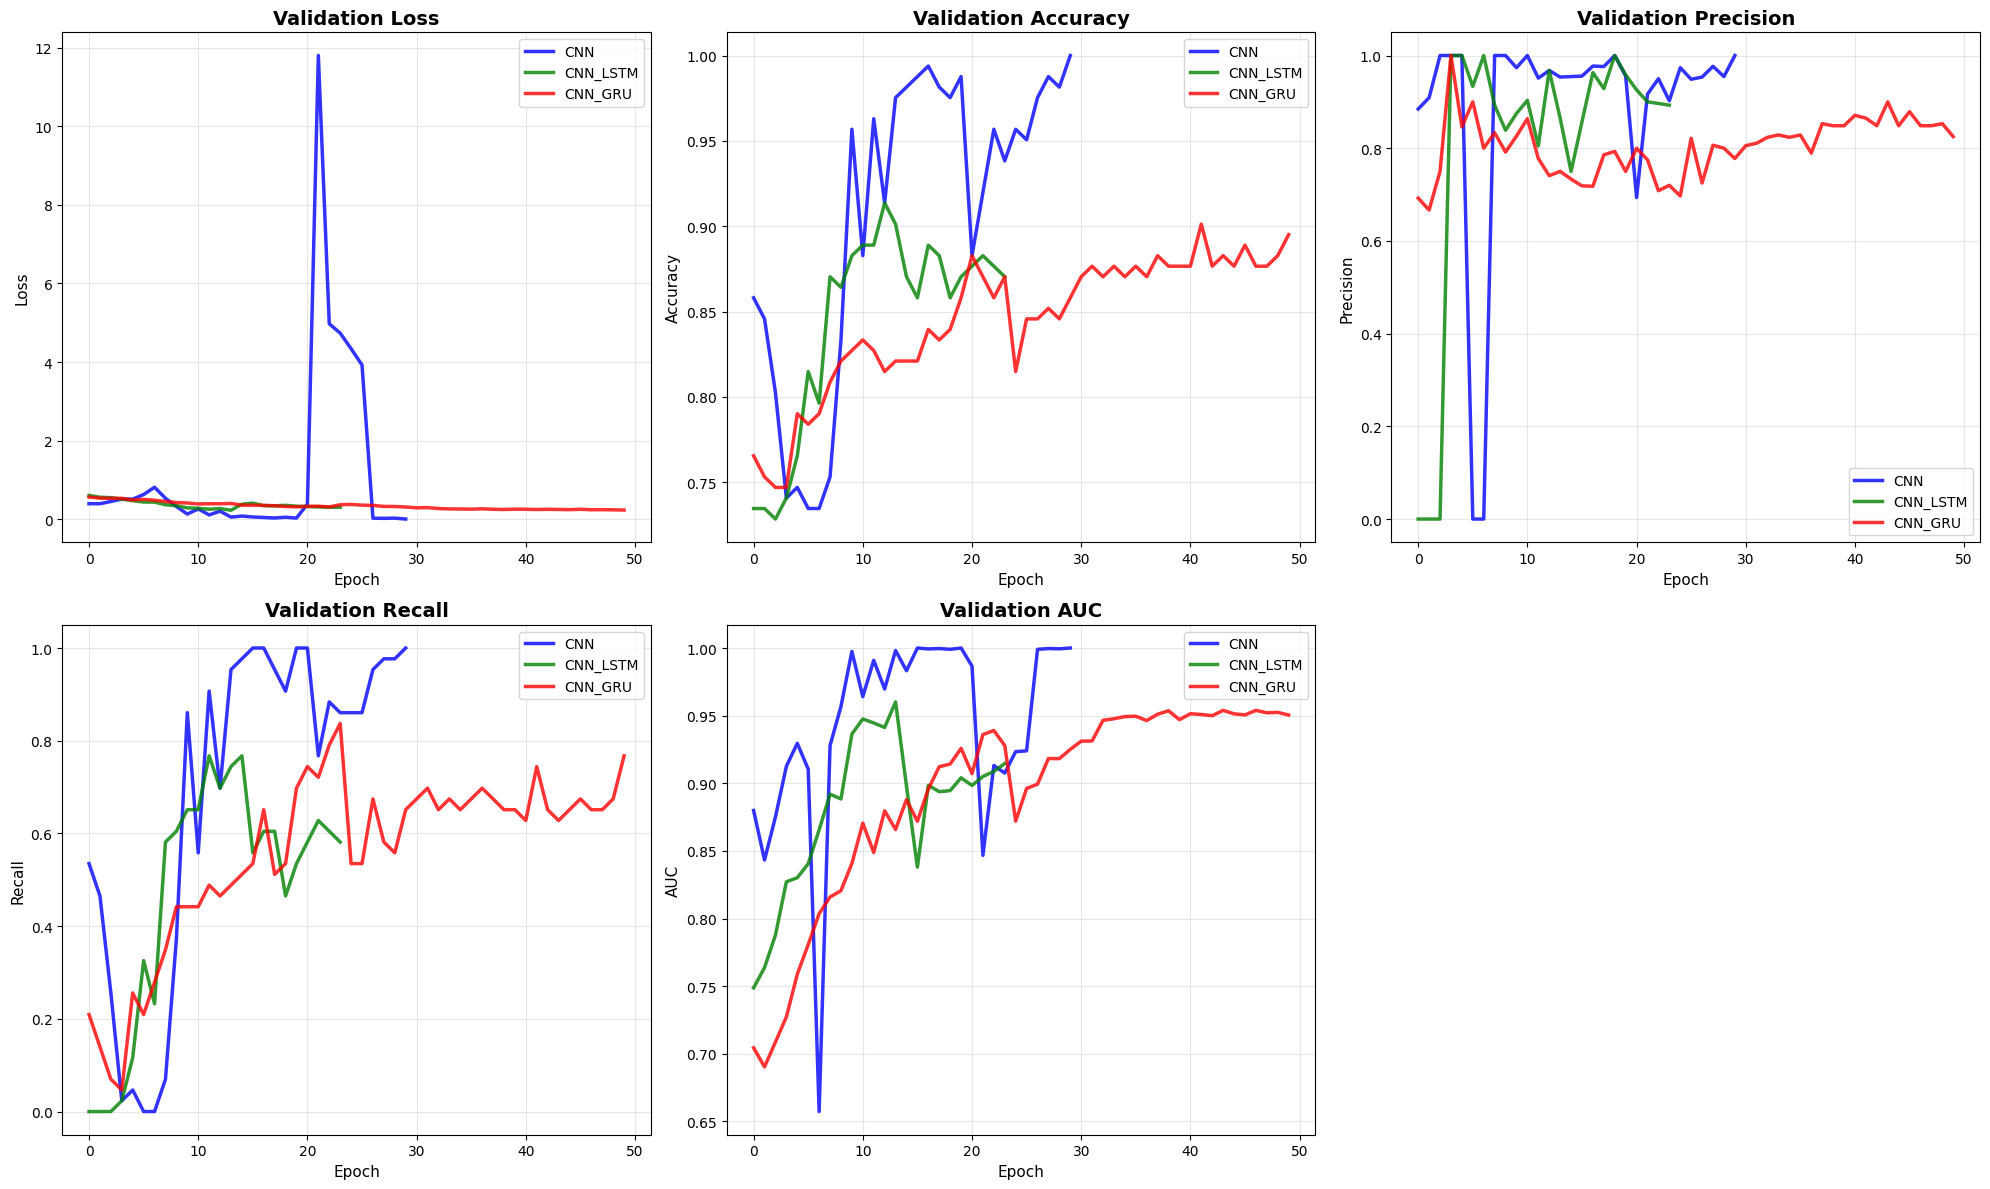

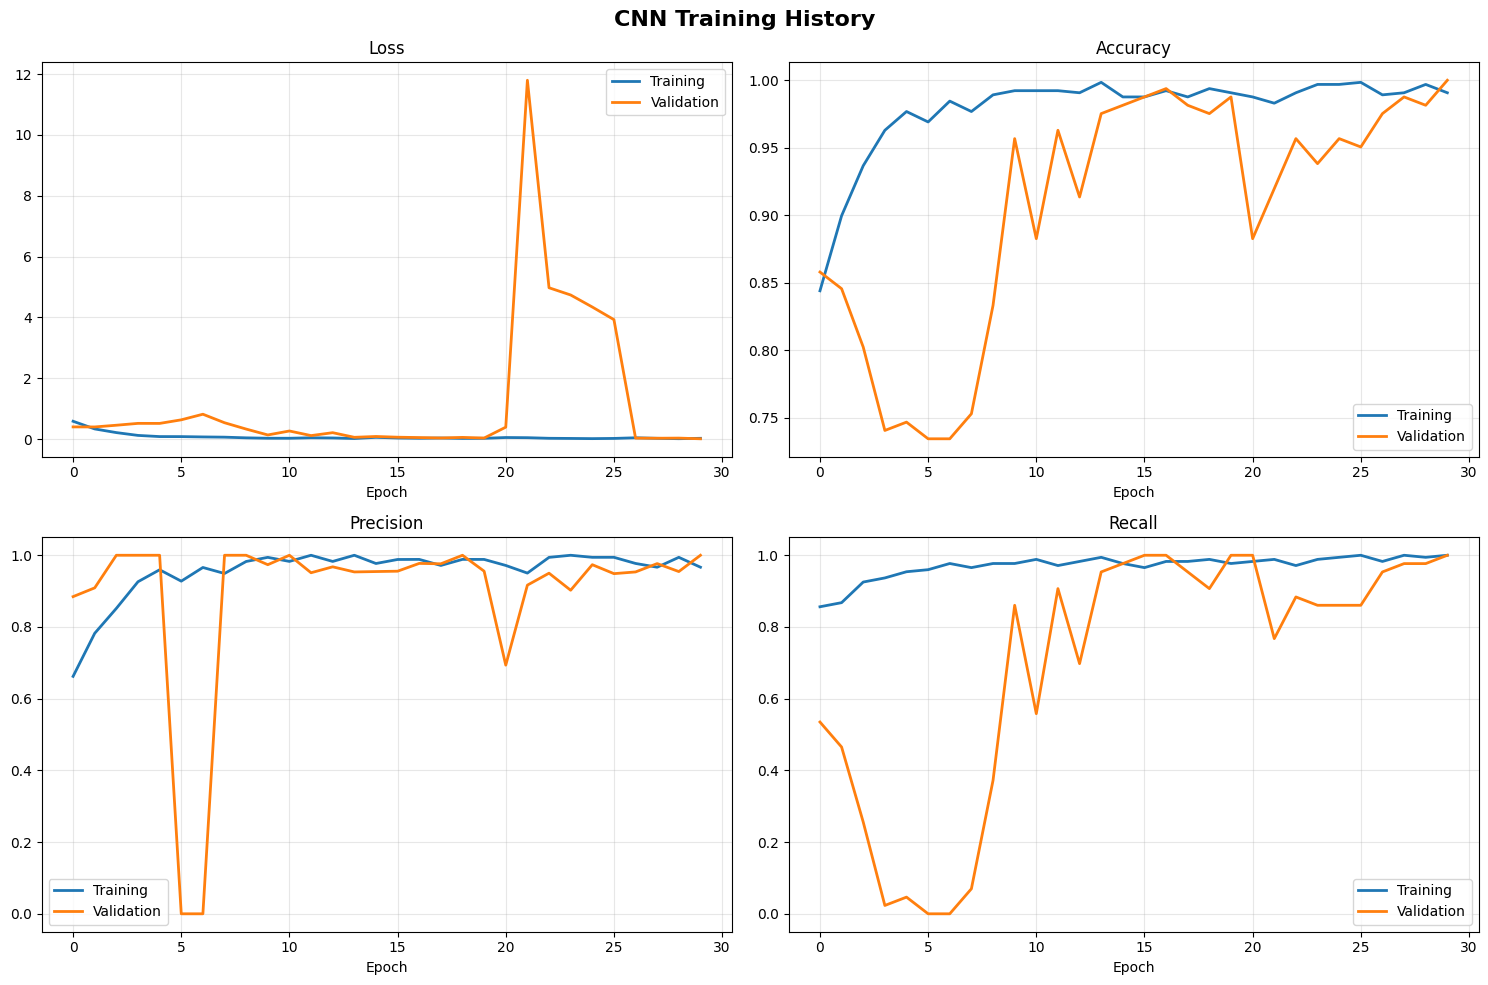

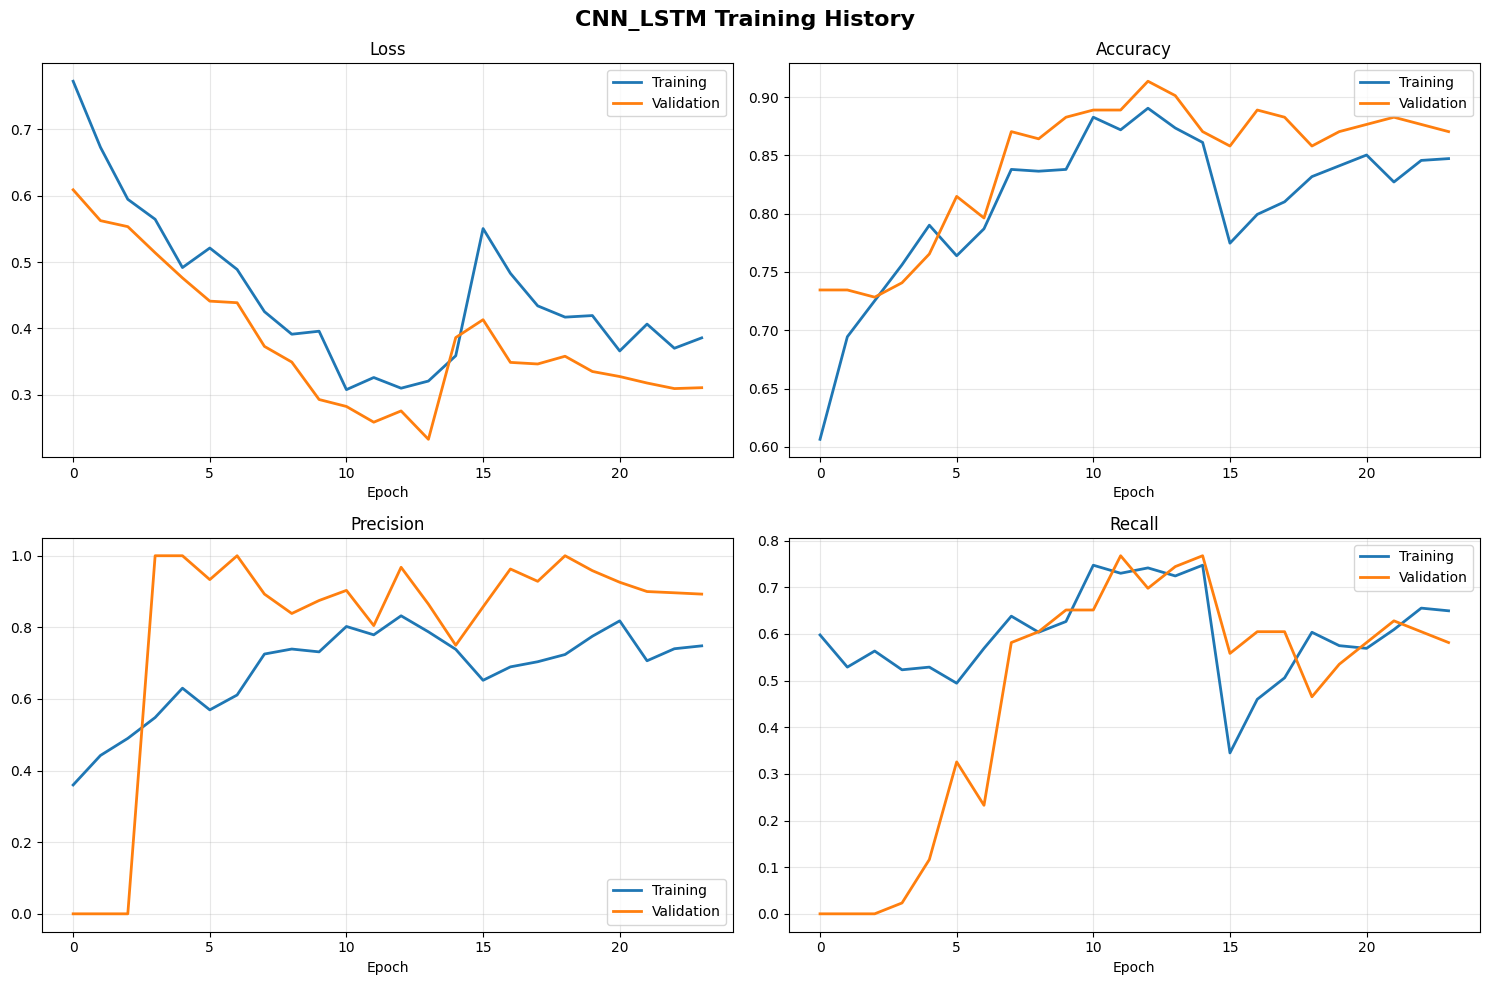

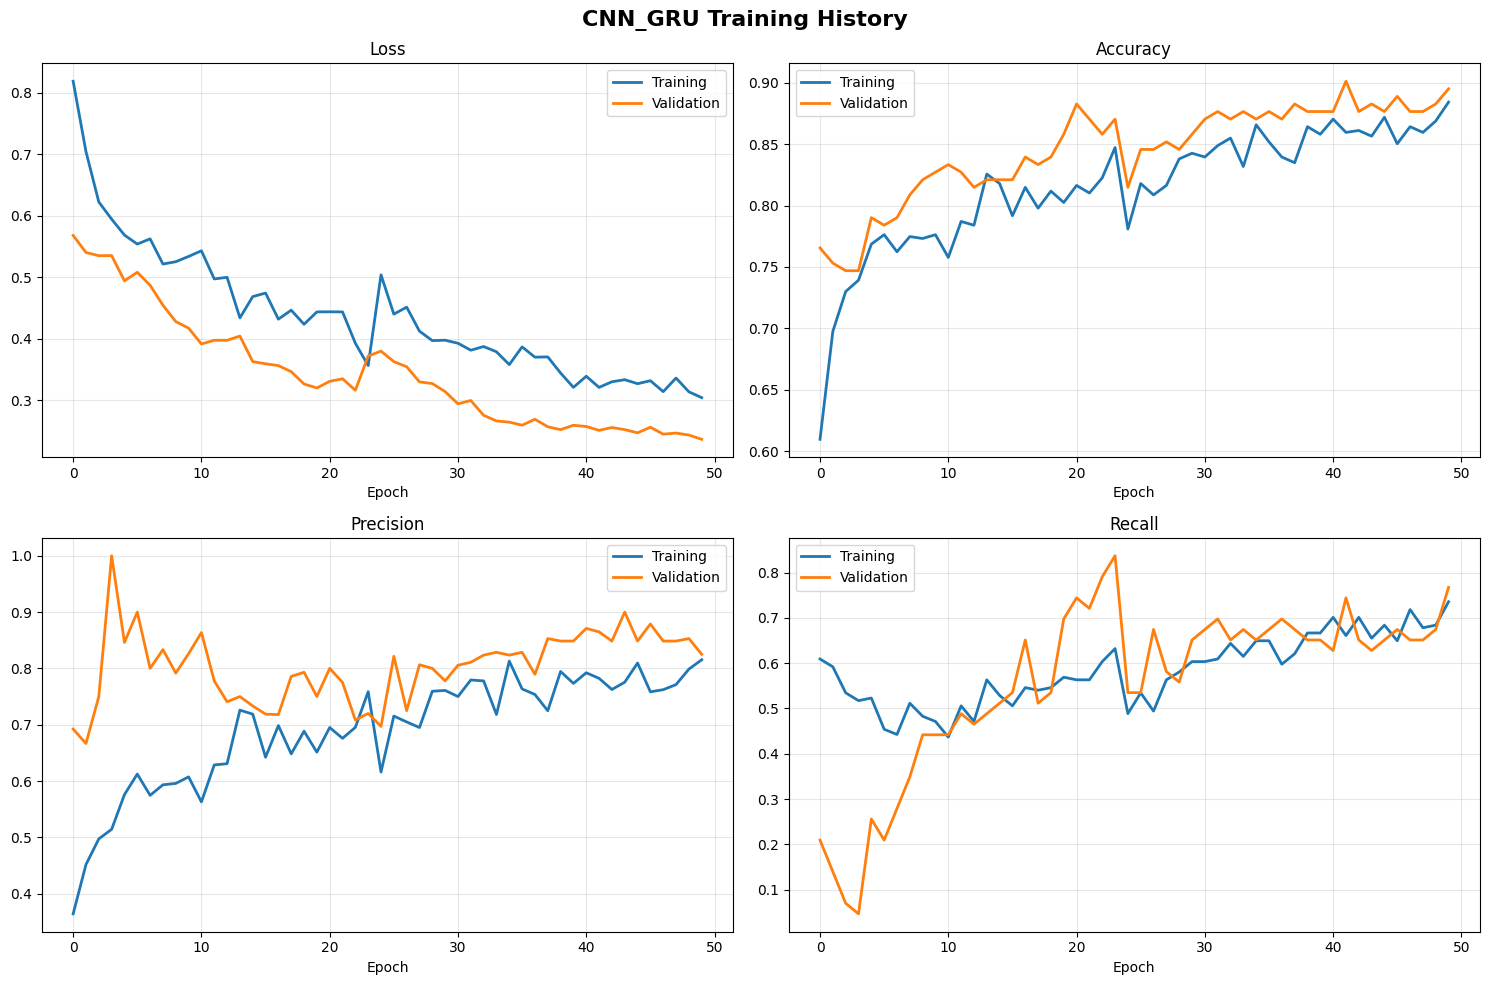

In [87]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc']
metric_titles = ['Loss', 'Accuracy', 'Precision', 'Recall', 'AUC']
colors = {'cnn': 'blue', 'cnn_lstm': 'green', 'cnn_gru': 'red'}

for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
    row = idx // 3
    col = idx % 3

    for model_type in CONFIG['model_types']:
        history = all_histories[model_type]
        axes[row, col].plot(history.history[f'val_{metric}'],
                           label=f'{model_type.upper()}',
                           linewidth=2.5,
                           color=colors[model_type],
                           alpha=0.8)

    axes[row, col].set_title(f'Validation {title}', fontsize=14, fontweight='bold')
    axes[row, col].set_xlabel('Epoch', fontsize=11)
    axes[row, col].set_ylabel(title, fontsize=11)
    axes[row, col].legend(fontsize=10)
    axes[row, col].grid(True, alpha=0.3)

# Remove extra subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Individual model training curves
for model_type in CONFIG['model_types']:
    history = all_histories[model_type]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_type.upper()} Training History', fontsize=16, fontweight='bold')

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 9. Comprehensive Model Evaluation and Comparison


EVALUATING CNN

CNN Classification Report:
              precision    recall  f1-score   support

Not Capuchin       1.00      1.00      1.00       119
    Capuchin       1.00      1.00      1.00        43

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162

EVALUATING CNN_LSTM

CNN_LSTM Classification Report:
              precision    recall  f1-score   support

Not Capuchin       0.91      0.96      0.93       119
    Capuchin       0.86      0.74      0.80        43

    accuracy                           0.90       162
   macro avg       0.89      0.85      0.87       162
weighted avg       0.90      0.90      0.90       162

EVALUATING CNN_GRU

CNN_GRU Classification Report:
              precision    recall  f1-score   support

Not Capuchin       0.92      0.94      0.93       119
    Capuchin       0.82      0.77      0.80        43

    accuracy                       

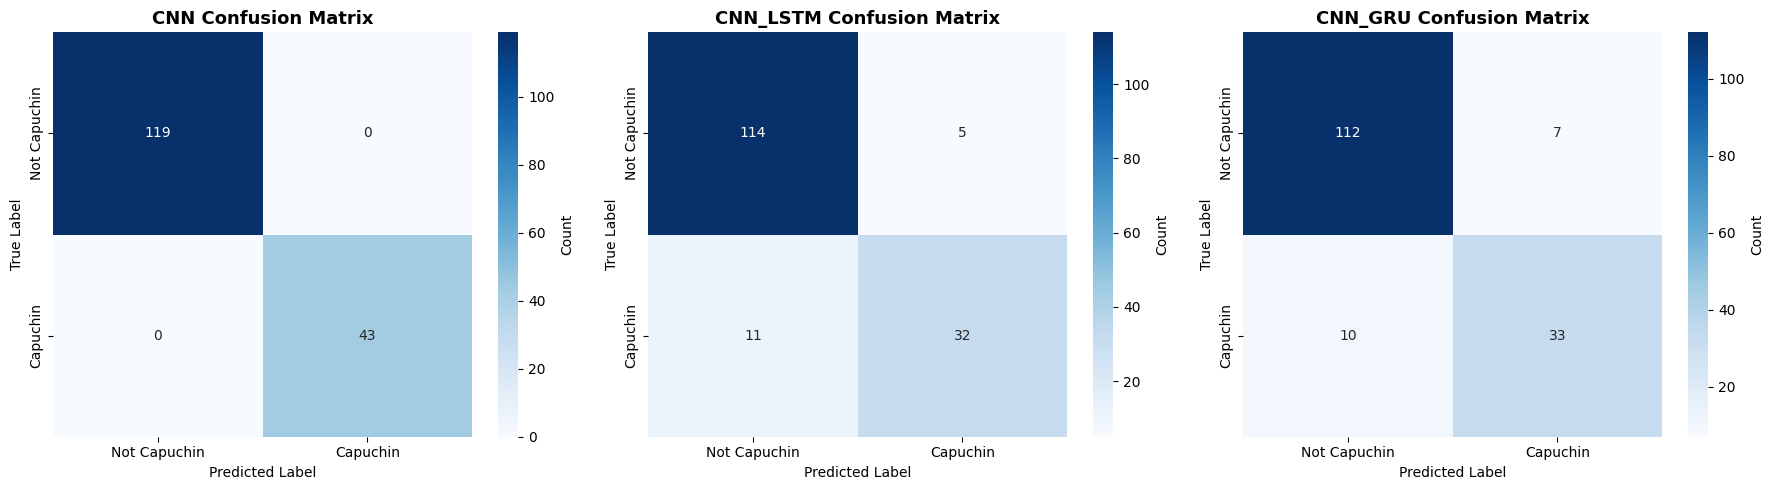

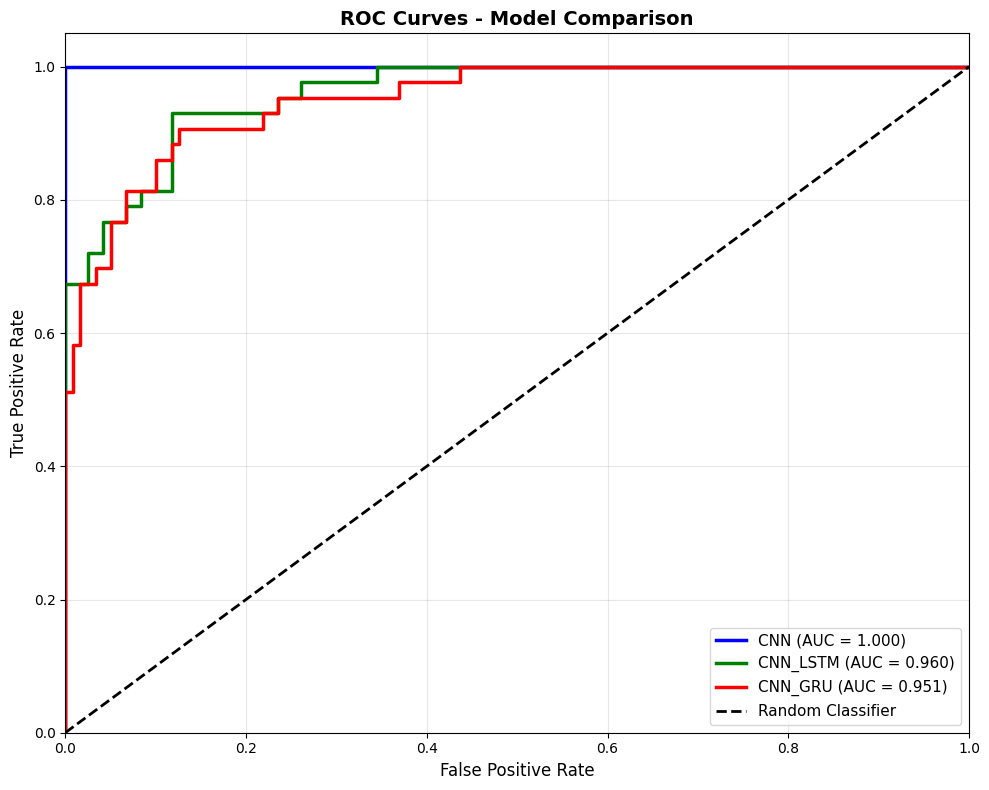

COMPREHENSIVE MODEL COMPARISON
   Model  Accuracy  Precision   Recall  F1-Score  Specificity      AUC  Parameters  Best Epoch
     cnn  1.000000   1.000000 1.000000  1.000000     1.000000 1.000000    30498753          20
cnn_lstm  0.901235   0.864865 0.744186  0.800000     0.957983 0.960133      139969          14
 cnn_gru  0.895062   0.825000 0.767442  0.795181     0.941176 0.950459      113729          47


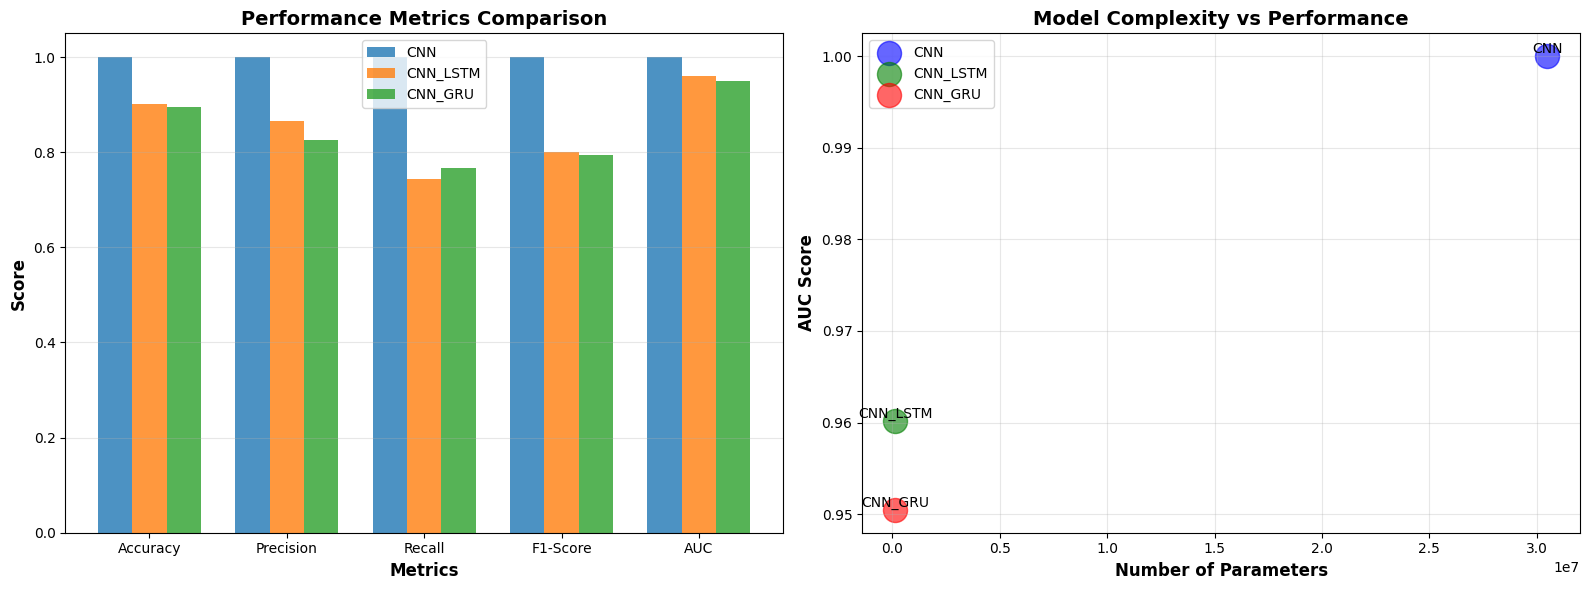


 BEST MODEL: CNN
   Best AUC Score: 1.0000

 Using CNN for forest recording analysis


In [88]:
# Evaluate all models and generate detailed comparisons
detailed_results = {}

for model_type in CONFIG['model_types']:
    print(f"EVALUATING {model_type.upper()}")

    model = all_models[model_type]

    # Get predictions
    y_pred_proba = model.predict(test_dataset, verbose=0)
    y_pred = (y_pred_proba > CONFIG['prediction_threshold']).astype(int).flatten()
    y_true = np.array(test_labels)

    # Classification report
    print(f"\n{model_type.upper()} Classification Report:")
    print(classification_report(y_true, y_pred,
                              target_names=['Not Capuchin', 'Capuchin']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Store detailed metrics
    detailed_results[model_type] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'f1': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0
    }

# Create comparison visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_type in enumerate(CONFIG['model_types']):
    cm = detailed_results[model_type]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Capuchin', 'Capuchin'],
                yticklabels=['Not Capuchin', 'Capuchin'],
                cbar_kws={'label': 'Count'})
    axes[idx].set_title(f'{model_type.upper()} Confusion Matrix',
                       fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ROC Curves comparison
plt.figure(figsize=(10, 8))
colors_roc = {'cnn': 'blue', 'cnn_lstm': 'green', 'cnn_gru': 'red'}

for model_type in CONFIG['model_types']:
    y_pred_proba = detailed_results[model_type]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2.5,
             label=f'{model_type.upper()} (AUC = {roc_auc:.3f})',
             color=colors_roc[model_type])

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create comprehensive comparison table
comparison_df = pd.DataFrame({
    'Model': CONFIG['model_types'],
    'Accuracy': [detailed_results[m]['accuracy'] for m in CONFIG['model_types']],
    'Precision': [detailed_results[m]['precision'] for m in CONFIG['model_types']],
    'Recall': [detailed_results[m]['recall'] for m in CONFIG['model_types']],
    'F1-Score': [detailed_results[m]['f1'] for m in CONFIG['model_types']],
    'Specificity': [detailed_results[m]['specificity'] for m in CONFIG['model_types']],
    'AUC': [all_results[m]['test_auc'] for m in CONFIG['model_types']],
    'Parameters': [all_results[m]['total_params'] for m in CONFIG['model_types']],
    'Best Epoch': [all_results[m]['best_epoch'] for m in CONFIG['model_types']]
})

print("COMPREHENSIVE MODEL COMPARISON")
print(comparison_df.to_string(index=False))

# Visualize metrics comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of key metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics_to_plot))
width = 0.25

for idx, model_type in enumerate(CONFIG['model_types']):
    values = comparison_df[comparison_df['Model'] == model_type][metrics_to_plot].values[0]
    axes[0].bar(x + idx*width, values, width,
               label=model_type.upper(), alpha=0.8)

axes[0].set_xlabel('Metrics', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.05])

# Model complexity vs performance
for model_type in CONFIG['model_types']:
    row = comparison_df[comparison_df['Model'] == model_type]
    axes[1].scatter(row['Parameters'], row['AUC'],
                   s=300, alpha=0.6,
                   label=model_type.upper(),
                   color=colors[model_type])
    axes[1].annotate(model_type.upper(),
                    (row['Parameters'].values[0], row['AUC'].values[0]),
                    fontsize=10, ha='center', va='bottom')

axes[1].set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AUC Score', fontsize=12, fontweight='bold')
axes[1].set_title('Model Complexity vs Performance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Determine best model
best_model_type = comparison_df.loc[comparison_df['AUC'].idxmax(), 'Model']
print(f"\n BEST MODEL: {best_model_type.upper()}")
print(f"   Best AUC Score: {comparison_df['AUC'].max():.4f}")

# Set the best model as the default for forest recording analysis
model = all_models[best_model_type]
print(f"\n Using {best_model_type.upper()} for forest recording analysis")

# 10. Forest Recording Analysis

In [89]:
print(f"Using {best_model_type.upper()} model for forest recording analysis")

Using CNN model for forest recording analysis


In [90]:
def preprocess_mp3(sample, index):
    """Preprocess audio samples for prediction"""
    sample = sample[0]
    zero_padding = tf.zeros([CONFIG['audio_length']] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav,
                                  frame_length=CONFIG['n_fft'],
                                  frame_step=CONFIG['hop_length'],
                                  fft_length=CONFIG['n_fft']) # Explicitly set fft_length
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [91]:
def analyze_recording(filepath, model, stride=16000):
    """Analyze a full recording for bird calls"""
    # Load audio
    wav = load_audio_16k(filepath)

    # Create sliding windows
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(
        wav, wav,
        sequence_length=CONFIG['audio_length'],
        sequence_stride=stride,
        batch_size=1
    )

    # Preprocess and batch
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    # Predict
    predictions = model.predict(audio_slices, verbose=0)

    return predictions

In [92]:
# DEMO: Quick test on one recording
import IPython.display as ipd

# Choose which recording to demo
DEMO_FILE = 'recording_100.mp3'  # Change this to test different files
demo_filepath = os.path.join(FOREST, DEMO_FILE)

print(f"Processing :{DEMO_FILE}")
# Play audio
display(ipd.Audio(demo_filepath))

# Analyze this recording
demo_wav = load_audio_16k(demo_filepath)
demo_slices = tf.keras.utils.timeseries_dataset_from_array(
    demo_wav, demo_wav,
    sequence_length=CONFIG['audio_length'],
    sequence_stride=16000,
    batch_size=1
)
demo_slices = demo_slices.map(preprocess_mp3)
demo_slices = demo_slices.batch(64)

# Predict
demo_predictions = model.predict(demo_slices, verbose=0)
demo_binary = [1 if p > CONFIG['detection_threshold'] else 0 for p in demo_predictions]
demo_grouped = [key for key, group in groupby(demo_binary)]
demo_calls = sum(demo_grouped)

print(f"Detected {demo_calls} Capuchinbird call(s) in {DEMO_FILE}")

Processing :recording_100.mp3


Detected 0 Capuchinbird call(s) in recording_100.mp3


In [93]:
# Choose which recording to demo
DEMO_FILE = 'recording_101.mp3'  # Change this to test different files
demo_filepath = os.path.join(FOREST, DEMO_FILE)

print(f"Processing :{DEMO_FILE}")
# Play audio
display(ipd.Audio(demo_filepath))

# Analyze this recording
demo_wav = load_audio_16k(demo_filepath)
demo_slices = tf.keras.utils.timeseries_dataset_from_array(
    demo_wav, demo_wav,
    sequence_length=CONFIG['audio_length'],
    sequence_stride=16000,
    batch_size=1
)
demo_slices = demo_slices.map(preprocess_mp3)
demo_slices = demo_slices.batch(64)

# Predict
demo_predictions = model.predict(demo_slices, verbose=0)
demo_binary = [1 if p > CONFIG['detection_threshold'] else 0 for p in demo_predictions]
demo_grouped = [key for key, group in groupby(demo_binary)]
demo_calls = sum(demo_grouped)

print(f"Detected {demo_calls} Capuchinbird call(s) in {DEMO_FILE}")

Processing :recording_101.mp3


Detected 3 Capuchinbird call(s) in recording_101.mp3


In [94]:
# Process all forest recordings
print("Analyzing forest recordings...")

results = {}
class_predictions = {}
postprocessed = {}

for file in sorted(os.listdir(FOREST)):
    if file.endswith('.mp3') or file.endswith('.wav'):
        filepath = os.path.join(FOREST, file)
        print(f"Processing: {file}")

        # Get predictions
        predictions = analyze_recording(filepath, model)
        results[file] = predictions

        # Convert to binary classes
        binary_preds = [1 if p > CONFIG['detection_threshold'] else 0
                       for p in predictions]
        class_predictions[file] = binary_preds

        # Group consecutive detections
        grouped = [key for key, group in groupby(binary_preds)]
        call_count = sum(grouped)
        postprocessed[file] = call_count

        print(f"  → Detected {call_count} Capuchinbird call(s)")

print("\n Analysis complete!")

Analyzing forest recordings...
Processing: recording_00.mp3
  → Detected 5 Capuchinbird call(s)
Processing: recording_01.mp3
  → Detected 0 Capuchinbird call(s)
Processing: recording_02.mp3
  → Detected 0 Capuchinbird call(s)
Processing: recording_03.mp3
  → Detected 0 Capuchinbird call(s)
Processing: recording_04.mp3
  → Detected 4 Capuchinbird call(s)
Processing: recording_05.mp3
  → Detected 0 Capuchinbird call(s)
Processing: recording_06.mp3
  → Detected 6 Capuchinbird call(s)
Processing: recording_07.mp3
  → Detected 2 Capuchinbird call(s)
Processing: recording_08.mp3
  → Detected 25 Capuchinbird call(s)
Processing: recording_09.mp3
  → Detected 0 Capuchinbird call(s)
Processing: recording_10.mp3
  → Detected 5 Capuchinbird call(s)
Processing: recording_100.mp3
  → Detected 0 Capuchinbird call(s)
Processing: recording_101.mp3
  → Detected 3 Capuchinbird call(s)
Processing: recording_11.mp3
  → Detected 3 Capuchinbird call(s)
Processing: recording_12.mp3
  → Detected 0 Capuchinbird

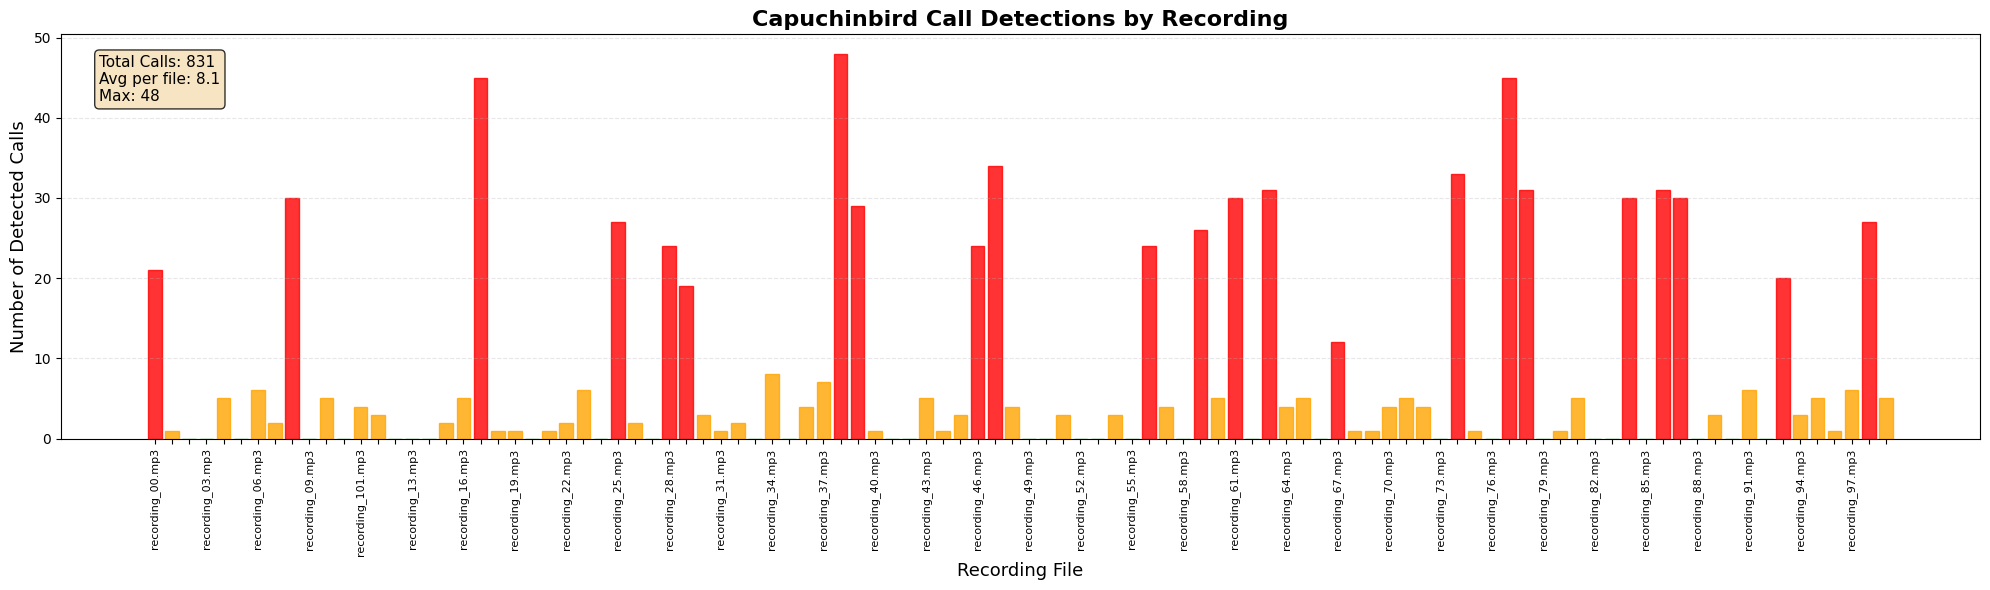

In [65]:
files = list(postprocessed.keys())
counts = list(postprocessed.values())

plt.figure(figsize=(20,6))
bars = plt.bar(range(len(files)), counts, edgecolor='black')

# Color bars by count category
colors = ['green' if c == 0 else 'orange' if c < 10 else 'red' for c in counts]
for bar, color in zip(bars, colors):
    bar.set_color(color)
    bar.set_alpha(0.8)

plt.title("Capuchinbird Call Detections by Recording", fontsize=16, fontweight='bold')
plt.xlabel("Recording File", fontsize=13)
plt.ylabel("Number of Detected Calls", fontsize=13)
plt.xticks(range(len(files)),
           [f if i % 3 == 0 else "" for i, f in enumerate(files)],
           rotation=90, fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.3)

# Summary box
total_calls = sum(counts)
avg_calls = np.mean(counts)
max_calls = max(counts)
text_box = f"Total Calls: {total_calls}\nAvg per file: {avg_calls:.1f}\nMax: {max_calls}"
plt.gca().text(0.02, 0.95, text_box, transform=plt.gca().transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


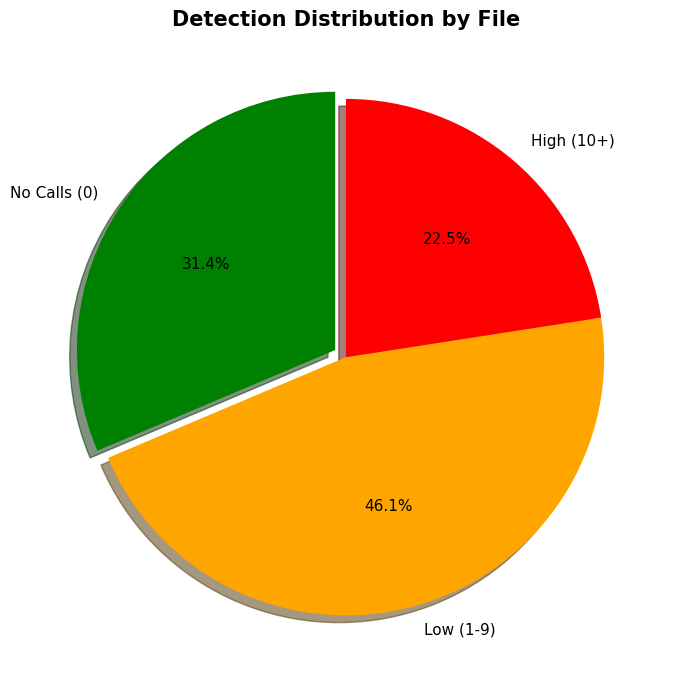

In [66]:
plt.figure(figsize=(7,7))

no_detection = sum(1 for c in counts if c == 0)
low_detection = sum(1 for c in counts if 0 < c < 10)
high_detection = sum(1 for c in counts if c >= 10)

sizes = [no_detection, low_detection, high_detection]
labels_pie = ['No Calls (0)', 'Low (1-9)', 'High (10+)']
colors_pie = ['green', 'orange', 'red']
explode = (0.05, 0, 0)

plt.pie(sizes,
        explode=explode,
        labels=labels_pie,
        colors=colors_pie,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90,
        textprops={'fontsize': 11})

plt.title("Detection Distribution by File", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()
